# Import Dependencies

In [1]:
import pandas as pd
from scipy.stats import f_oneway , chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_selection import SelectFromModel , VarianceThreshold
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.sparse import csr_matrix
#import polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from tensorflow import keras
from sklearn.base import BaseEstimator, RegressorMixin


In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('/content/Airbnb_Data.csv')
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [5]:
data.isnull().sum()

,0
id,0
log_price,0
property_type,0
room_type,0
amenities,0
accommodates,0
bathrooms,200
bed_type,0
cancellation_policy,0
cleaning_fee,0


# EDA

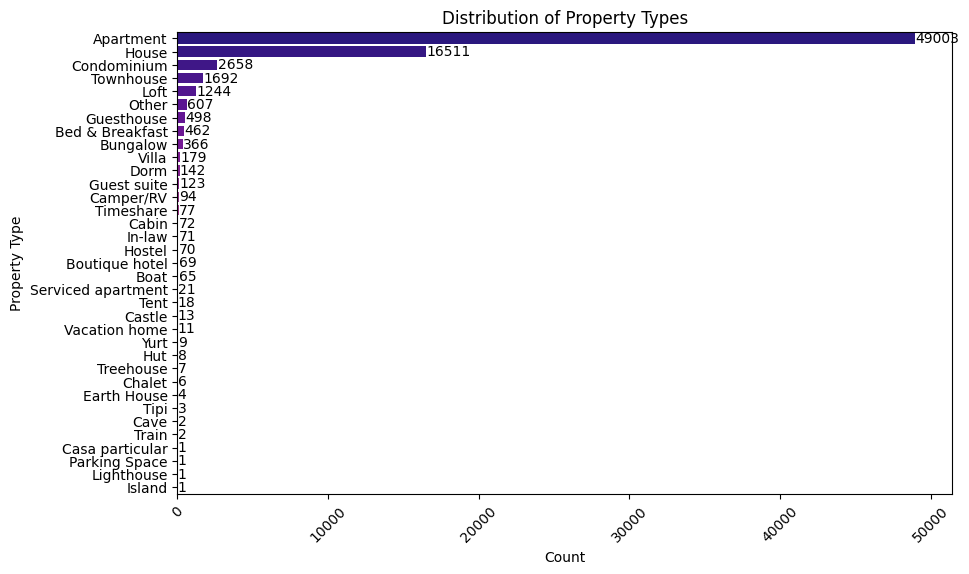

In [6]:
# Count the frequency of each unique value in 'property_type'
value_counts = data['property_type'].value_counts()

# Plotting using horizontal bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=value_counts.values, y=value_counts.index, palette='plasma')

# Customizing the plot
plt.title('Distribution of Property Types')
plt.xlabel('Count')
plt.ylabel('Property Type')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show value count for each bar
for i, v in enumerate(value_counts.values):
    ax.text(v + 10, i, str(v), color='black', va='center')

plt.show()

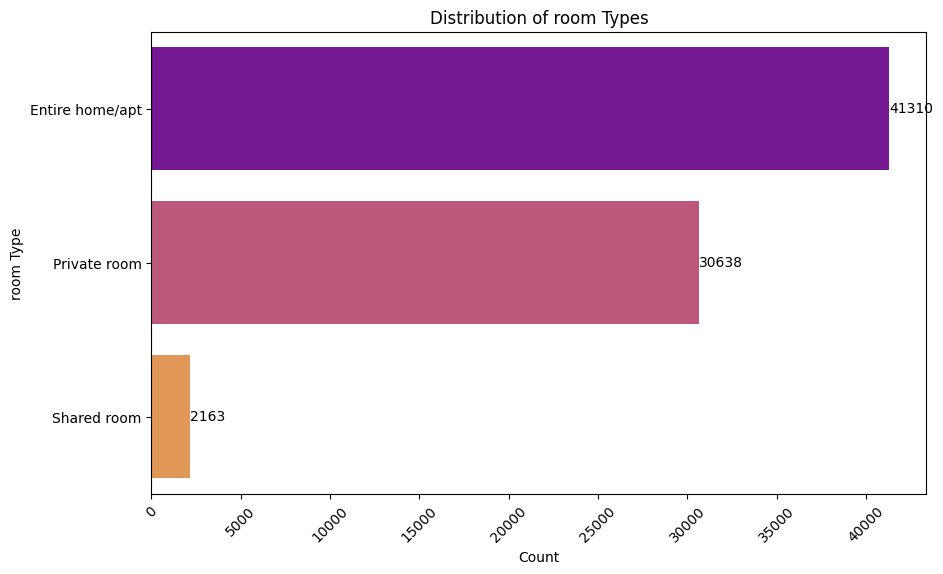

In [7]:
# Count the frequency of each unique value in 'room_type'
value_counts = data['room_type'].value_counts()

# Plotting using horizontal bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=value_counts.values, y=value_counts.index, palette='plasma')

# Customizing the plot
plt.title('Distribution of room Types')
plt.xlabel('Count')
plt.ylabel('room Type')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show value count for each bar
for i, v in enumerate(value_counts.values):
    ax.text(v + 10, i, str(v), color='black', va='center')

plt.show()

In [8]:
data['longitude'].nunique()

74111

latitude', 'longitude', 'city

# Missing value imputation

By understanding the data distribution across data  we assumes that **Bathrooms** are dependent on **property_type** and **room_type** so for imputation we will do imputation based on this

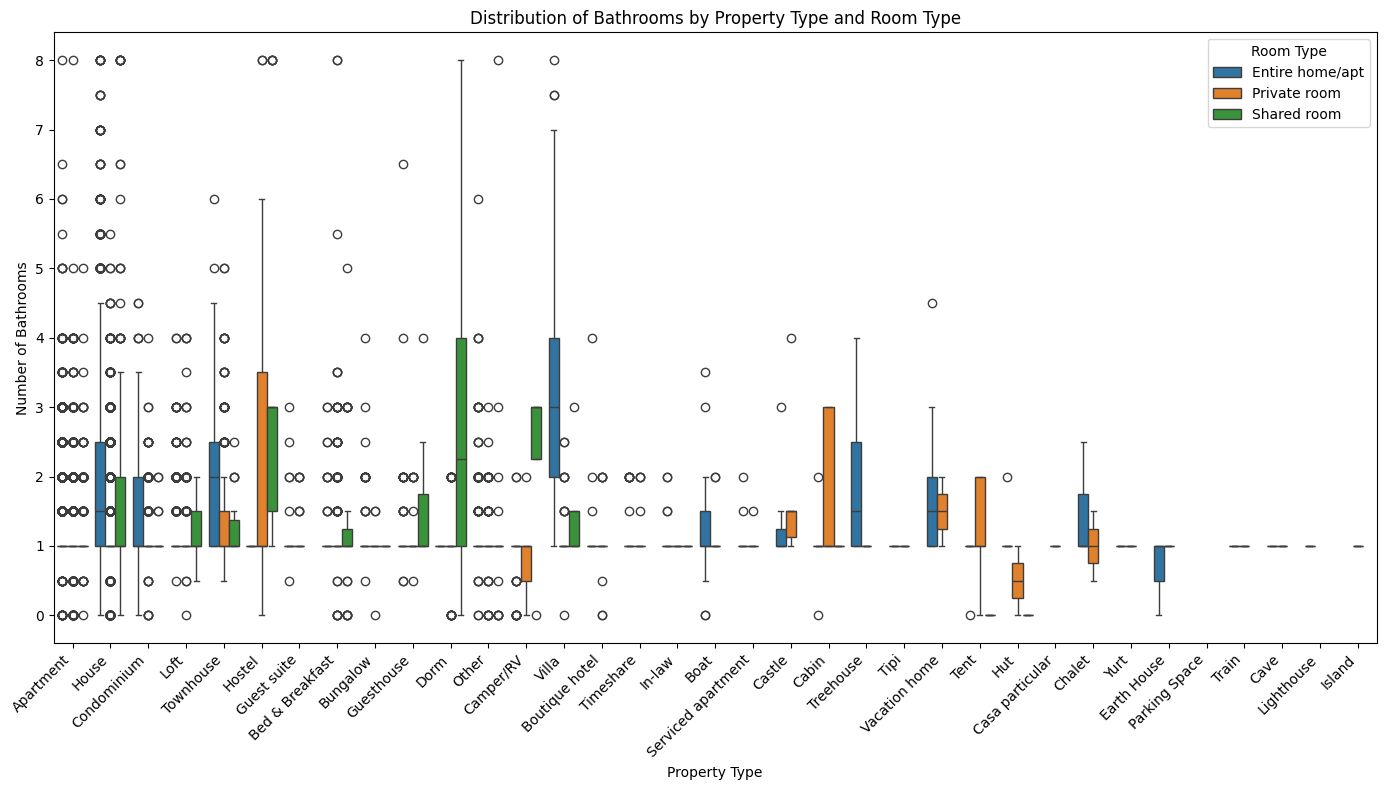

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped box plot to visualize the distribution of bathrooms for each combination of property type and room type
# This plot helps to understand how both property type and room type together influence the number of bathrooms.
plt.figure(figsize=(14, 8))
sns.boxplot(x='property_type', y='bathrooms', hue='room_type', data=data)
plt.title('Distribution of Bathrooms by Property Type and Room Type')
plt.xlabel('Property Type')
plt.ylabel('Number of Bathrooms')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

In [10]:
# Impute missing 'bathrooms' based on the mean of 'property_type' and 'room_type'
data['bathrooms'] = data.groupby(['property_type', 'room_type'])['bathrooms'].transform(lambda x: x.fillna(x.mean()))

# If there are still missing values, impute them with the overall mean of 'bathrooms'
overall_mean_bathrooms = data['bathrooms'].mean()
data['bathrooms'].fillna(overall_mean_bathrooms, inplace=True)




is_host_since_null                                           False  True 
is_host_has_profile_pic_null is_host_identity_verified_null              
False                        False                           73923      0
True                         True                                0    188


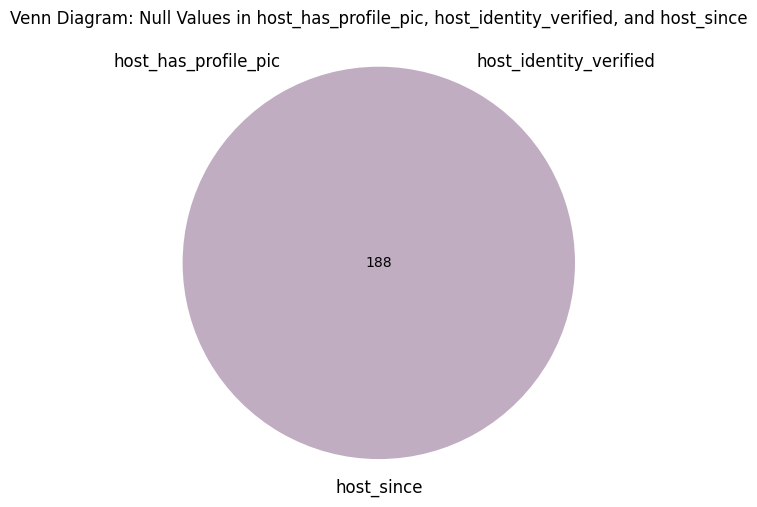

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib_venn import venn3

# Create binary columns indicating missing values
data['is_host_has_profile_pic_null'] = data['host_has_profile_pic'].isna()
data['is_host_identity_verified_null'] = data['host_identity_verified'].isna()
data['is_host_since_null'] = data['host_since'].isna()

# Create a crosstab to count the number of missing values in each combination of columns
null_distribution = pd.crosstab([data['is_host_has_profile_pic_null'],
                                 data['is_host_identity_verified_null']],
                                data['is_host_since_null'])

# Print the count of missing value combinations
print(null_distribution)

venn_data = {
    '100': 0,  # Only 'host_has_profile_pic' null (not observed)
    '010': 0,  # Only 'host_identity_verified' null (not observed)
    '001': 0,  # Only 'host_since' null (not observed)
    '110': 0,  # 'host_has_profile_pic' & 'host_identity_verified' null (not observed alone)
    '011': 0,  # 'host_identity_verified' & 'host_since' null (not observed alone)
    '101': 0,  # 'host_has_profile_pic' & 'host_since' null (not observed alone)
    '111': null_distribution.loc[(True, True), True] if (True, True) in null_distribution.index and True in null_distribution.columns else 0 # All three columns null
}

# Add the count for when none are null, which should be the total number of rows minus the '111' case
total_rows = data.shape[0]
venn_data['000'] = total_rows - venn_data['111']

# Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn3(subsets=venn_data, set_labels=('host_has_profile_pic', 'host_identity_verified', 'host_since'))
plt.title("Venn Diagram: Null Values in host_has_profile_pic, host_identity_verified, and host_since")
plt.show()

In [12]:
#for host_has_profile_pic and host_identity_verified we will drop as both hav same data mising
data.dropna(subset=['host_has_profile_pic', 'host_identity_verified', 'host_since'], axis=0, inplace=True)


 **Zero Bedrooms** for "**Entire home/apt**" properties is likely a **data issue**, and imputing bedrooms with a **median bedroom count** for similar listings is a reasonable approach which we will be using

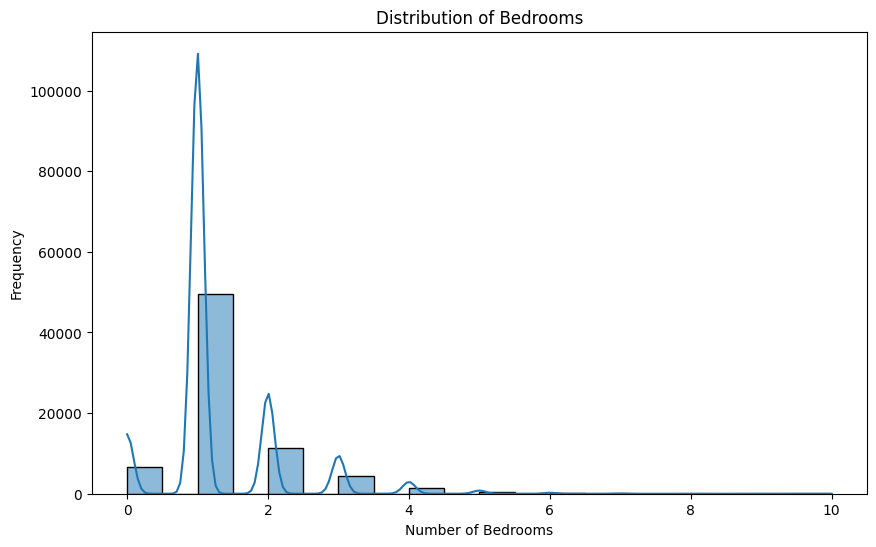

In [13]:
#plot bedrooms data as univarite
plt.figure(figsize=(10, 6))
sns.histplot(data['bedrooms'], bins=20, kde=True)
plt.title('Distribution of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Check the distribution of room types and accommodates
data[data['bedrooms'] == 0][['room_type', 'accommodates', 'log_price']]


,room_type,accommodates,log_price
4,Entire home/apt,2,4.744932
55,Entire home/apt,5,4.744932
64,Entire home/apt,1,4.700480
69,Entire home/apt,2,4.499810
96,Entire home/apt,1,4.248495
...,...,...,...
74086,Private room,2,4.174387
74087,Entire home/apt,4,4.477337
74091,Entire home/apt,2,5.010635
74098,Entire home/apt,4,4.553877


In [15]:
#  Impute bedrooms where bedrooms == 0 for 'Entire home/apt' or 'Private room' room types
median_bedrooms_entire_home = data[data['room_type'] == 'Entire home/apt']['bedrooms'].median()
data.loc[(data['bedrooms'] == 0) & (data['room_type'].isin(['Entire home/apt', 'Private room'])), 'bedrooms'] = median_bedrooms_entire_home

#  General imputation of missing bedrooms using property_type and room_type groups
data['bedrooms'] = data.groupby(['property_type', 'room_type'])['bedrooms'].transform(lambda x: x.fillna(x.median()))




now for **beds** we will imputate this with roomtype and property_type


In [16]:
#impute bedrooms and beds on the basis of roomtype and property type
data['beds'] = data.groupby(['property_type', 'room_type'])['beds'].transform(lambda x: x.fillna(x.median()))

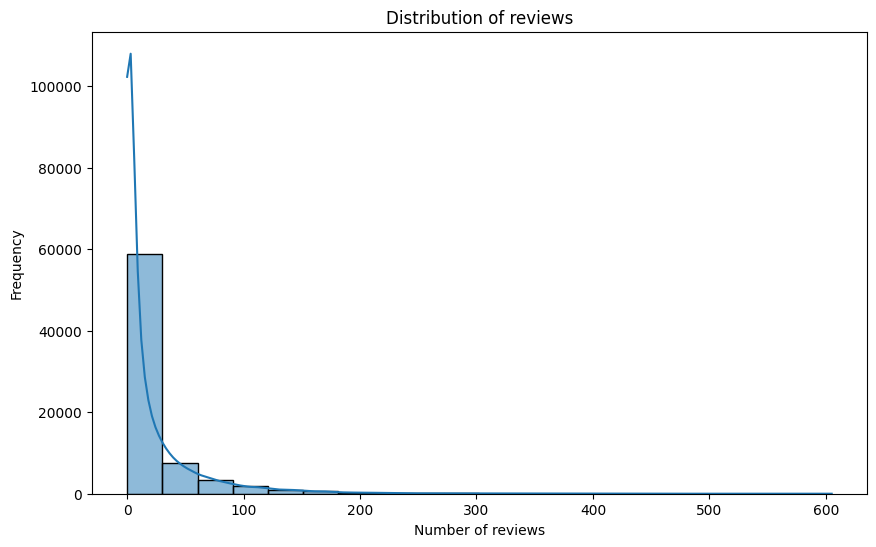

In [17]:
#plot reviews data as univarite
plt.figure(figsize=(10, 6))
sns.histplot(data['number_of_reviews'], bins=20, kde=True)
plt.title('Distribution of reviews')
plt.xlabel('Number of reviews')
plt.ylabel('Frequency')
plt.show()

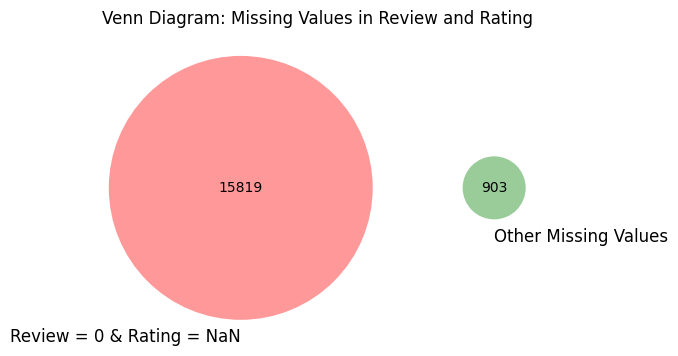

In [18]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Number of missing values
total_missing = 16722
filtered_missing = 15819
other_missing = total_missing - filtered_missing

# Create a Venn diagram to visualize the overlap
venn_data = {
    '10': filtered_missing,   # Only review_scores_rating is NaN and number_of_reviews is 0
    '01': other_missing,      # Other missing values
    '11': 0,                  # No overlap, as we're only interested in these two conditions
}

# Plotting the Venn diagram
plt.figure(figsize=(6, 6))
venn = venn2(subsets=venn_data, set_labels=('Review = 0 & Rating = NaN', 'Other Missing Values'))
plt.title('Venn Diagram: Missing Values in Review and Rating')

# Display the plot
plt.show()


In [19]:
# Check where 'review' is 0 and 'review_scores_rating' is NaN
nan_reviews = data[(data['number_of_reviews'] == 0) & (data['review_scores_rating'].isna())]

# Count the number of such entries
print("Number of entries where review is 0 and review_scores_rating is NaN:", nan_reviews.shape[0])

# Check where 'review' is not null and get the value of 'review'
non_null_reviews = data[data['number_of_reviews'].notna()]
#print("Review values when 'review' is not null:", non_null_reviews['number_of_reviews'].unique())


Number of entries where review is 0 and review_scores_rating is NaN: 15783


In [20]:
#  Impute 'review_scores_rating' to 0 when 'review' is 0
data.loc[data['number_of_reviews'] == 0, 'review_scores_rating'] = 0

#  Impute remaining NaN values in 'review_scores_rating' with the median
median_review_score = data['review_scores_rating'].median()
data['review_scores_rating'].fillna(median_review_score, inplace=True)


In [21]:
# Impute 'neighbourhood' by grouping by 'zipcode', 'latitude', 'longitude', 'city'
data['neighbourhood'] = data.groupby(['latitude', 'longitude', 'city'])['neighbourhood']\
    .transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(data['neighbourhood'].mode()[0]))

# Impute 'zipcode' by grouping by 'latitude', 'longitude', and 'city'
data['zipcode'] = data.groupby(['latitude', 'longitude', 'city'])['zipcode']\
    .transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(data['zipcode'].mode()[0]))


In [22]:
data.isnull().sum()

,0
id,0
log_price,0
property_type,0
room_type,0
amenities,0
accommodates,0
bathrooms,0
bed_type,0
cancellation_policy,0
cleaning_fee,0


In [23]:
# Convert 'host_response_rate' to numeric, handling '%' and NaNs
data['host_response_rate'] = data['host_response_rate'].str.replace('%', '').astype(float)

# impute host_response_rate based on 'host_has_profile_pic', 'host_identity_verified', 'host_since'
# If group median is not available, use the overall median of host_response_rate
overall_median_response_rate = data['host_response_rate'].median()
data['host_response_rate'] = data.groupby(['host_has_profile_pic', 'host_identity_verified', 'host_since'])['host_response_rate'].transform(lambda x: x.fillna(x.median() if not pd.isna(x.median()) else overall_median_response_rate))

In [24]:
# Convert to datetime format (if not already done)
data['first_review'] = pd.to_datetime(data['first_review'], errors='coerce')
data['last_review'] = pd.to_datetime(data['last_review'], errors='coerce')


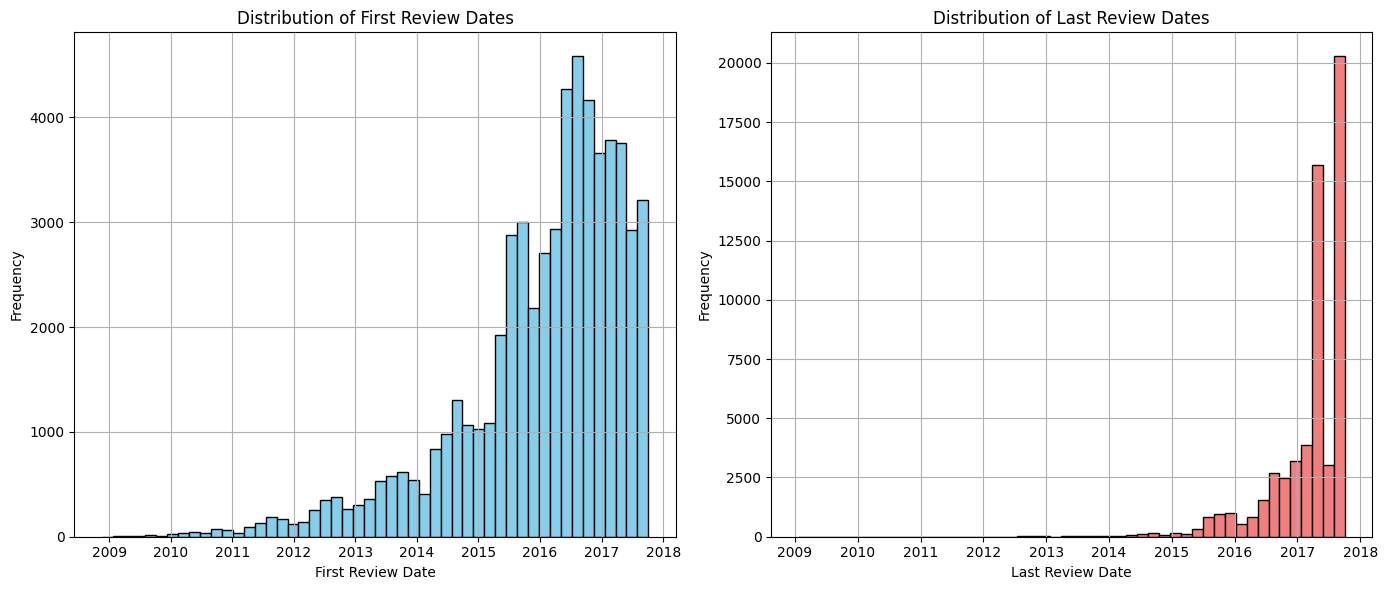

In [25]:


# Plot histograms for first_review and last_review
plt.figure(figsize=(14, 6))

# First Review Histogram
plt.subplot(1, 2, 1)
data['first_review'].dropna().hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of First Review Dates')
plt.xlabel('First Review Date')
plt.ylabel('Frequency')

# Last Review Histogram
plt.subplot(1, 2, 2)
data['last_review'].dropna().hist(bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of Last Review Dates')
plt.xlabel('Last Review Date')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [26]:
median_first_review = data['first_review'].median()
data['first_review'].fillna(median_first_review, inplace=True)
median_last_review = data['last_review'].median()
data['last_review'].fillna(median_last_review, inplace=True)

In [27]:
# Set a placeholder image URL for missing thumbnail URLs
placeholder_url = 'https://www.google.com/search?sca_esv=637c0e90f834ed3d&rlz=1C1CHBF_enPK1153PK1153&sxsrf=AE3TifM1Tr7p3wrjESCShM7PV_0bq0lFjQ:1758613022932&udm=2&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZ1Y6MJ25_tmWITc7uy4KIeoJTKjrFjVxydQWqI2NcOhYPURIv2wPgv_w_sE_0Sc6QqqU7k8cSQndc5mTXCIWHa5yWh8UZLeaMB2TzsL707pc1UdUOyvWrdH9KzB0rwa56e4sZMK6yB9HCSc5sZ95qH7WhtZ4UgYYwhFKAtUJ9yDKl7bQ8&q=no+image+available&sa=X&ved=2ahUKEwiNxp2EsO6PAxWDS_EDHZ29HQUQtKgLegQIEhAB&biw=1280&bih=559&dpr=1.5#vhid=eTmuGeq2FpQqAM&vssid=mosaic'
data['thumbnail_url'].fillna(placeholder_url, inplace=True)


In [28]:
#CHECK Duplicate Entries
data.duplicated().sum()

np.int64(0)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73923 entries, 0 to 74110
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              73923 non-null  int64         
 1   log_price                       73923 non-null  float64       
 2   property_type                   73923 non-null  object        
 3   room_type                       73923 non-null  object        
 4   amenities                       73923 non-null  object        
 5   accommodates                    73923 non-null  int64         
 6   bathrooms                       73923 non-null  float64       
 7   bed_type                        73923 non-null  object        
 8   cancellation_policy             73923 non-null  object        
 9   cleaning_fee                    73923 non-null  bool          
 10  city                            73923 non-null  object        
 11  descrip

# Univariate analysis

In [30]:
data.describe()

,id,log_price,accommodates,bathrooms,first_review,host_response_rate,last_review,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.392300e+04,73923.000000,73923.000000,73923.000000,73923,73923.000000,73923,73923.000000,73923.000000,73923.000000,73923.000000,73923.000000,73923.000000
mean,1.126700e+07,4.782190,3.156487,1.235610,2016-02-11 14:02:31.065297664,95.421107,2017-03-24 06:30:45.801712384,38.441071,-92.437653,20.905266,73.983212,1.356587,1.710726
min,3.440000e+02,0.000000,1.000000,0.000000,2008-11-17 00:00:00,0.000000,2009-01-21 00:00:00,33.338905,-122.511500,0.000000,0.000000,1.000000,0.000000
25%,6.262122e+06,4.317488,2.000000,1.000000,2015-09-21 00:00:00,100.000000,2017-03-24 00:00:00,34.126806,-118.342758,1.000000,80.000000,1.000000,1.000000
50%,1.225468e+07,4.709530,2.000000,1.000000,2016-05-25 00:00:00,100.000000,2017-04-28 00:00:00,40.661531,-76.998346,6.000000,94.000000,1.000000,1.000000
75%,1.640204e+07,5.220356,4.000000,1.000000,2016-10-26 00:00:00,100.000000,2017-08-20 00:00:00,40.746034,-73.954686,23.000000,99.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,2017-10-05 00:00:00,100.000000,2017-10-05 00:00:00,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000
std,6.081705e+06,0.717617,2.154869,0.581969,NaN,14.691334,NaN,3.081674,21.711718,37.838483,39.159574,0.761041,1.254111


# Feaature Selection

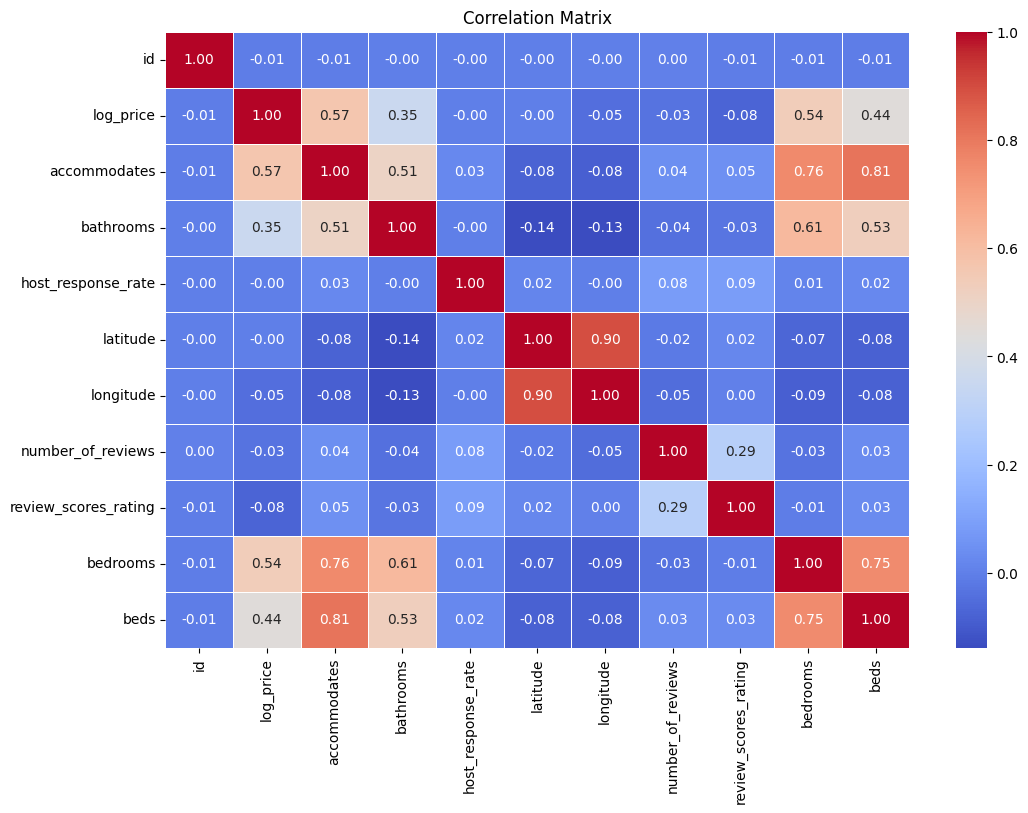

Dropping column due to high correlation: accommodates
Dropping column due to high correlation: latitude
Dropping column due to high correlation: longitude
Dropping column due to high correlation: bedrooms
Dropping column due to high correlation: beds


In [31]:
# Select only numerical columns for correlation matrix calculation
numerical_cols = data.select_dtypes(include=np.number).columns

# Correlation Matrix for Numerical Features
corr_matrix = data[numerical_cols].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Set a stricter correlation threshold, e.g., 0.85
threshold = 0.7
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_var = [(i, j) for i, j in zip(*high_corr_var) if i != j]

# Drop the columns that have high correlation
dropped_columns = []
for i, j in high_corr_var:
    colname = corr_matrix.columns[i]
    if colname not in dropped_columns:  # Ensure each column is only dropped once
        dropped_columns.append(colname)
        print(f"Dropping column due to high correlation: {colname}")
        data = data.drop(columns=[colname])

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73923 entries, 0 to 74110
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              73923 non-null  int64         
 1   log_price                       73923 non-null  float64       
 2   property_type                   73923 non-null  object        
 3   room_type                       73923 non-null  object        
 4   amenities                       73923 non-null  object        
 5   bathrooms                       73923 non-null  float64       
 6   bed_type                        73923 non-null  object        
 7   cancellation_policy             73923 non-null  object        
 8   cleaning_fee                    73923 non-null  bool          
 9   city                            73923 non-null  object        
 10  description                     73923 non-null  object        
 11  first_r

In [33]:
# Convert 'log_price' to categorical (price_category) for Chi-Square
data['price_category'] = pd.qcut(data['log_price'], q=4, labels=["Low", "Medium", "High", "Very High"])

# For Chi-Square: Check p-values for categorical features
categorical_columns = data.select_dtypes(include='object').columns
significant_categorical = []
non_significant_categorical = []  # To store non-significant features

# Set a stricter p-value threshold to drop more columns
threshold = 0.0001  # Can be adjusted to 0.001 for an even stricter criterion

for feature in categorical_columns:
    if feature != 'price_category':  # Don't include the target variable
        contingency_table = pd.crosstab(data[feature], data['price_category'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"Chi-Square Test for {feature}: p-value = {p}")

        # Collect significant and non-significant features
        if p < threshold:
            significant_categorical.append(feature)
            print(f"Feature {feature} is significant.")
        else:
            non_significant_categorical.append(feature)
            print(f"Feature {feature} is NOT significant.")

# List of significant categorical features
print(f"\nSignificant Categorical Features: {significant_categorical}")
print(f"Non-Significant Categorical Features: {non_significant_categorical}")


Chi-Square Test for property_type: p-value = 0.0
Feature property_type is significant.
Chi-Square Test for room_type: p-value = 0.0
Feature room_type is significant.
Chi-Square Test for amenities: p-value = 4.792480073045723e-13
Feature amenities is significant.
Chi-Square Test for bed_type: p-value = 4.7049009774325665e-181
Feature bed_type is significant.
Chi-Square Test for cancellation_policy: p-value = 0.0
Feature cancellation_policy is significant.
Chi-Square Test for city: p-value = 0.0
Feature city is significant.
Chi-Square Test for description: p-value = 0.012757937633587074
Feature description is NOT significant.
Chi-Square Test for host_has_profile_pic: p-value = 0.002148570395607985
Feature host_has_profile_pic is NOT significant.
Chi-Square Test for host_identity_verified: p-value = 3.627810727585609e-48
Feature host_identity_verified is significant.
Chi-Square Test for host_since: p-value = 1.937473786041612e-179
Feature host_since is significant.
Chi-Square Test for ins

In [34]:
 #drop name and thumbnail_url
data.drop(columns=['description', 'host_has_profile_pic', 'name', 'thumbnail_url'], inplace=True)

In [35]:
# Drop categorical columns with too many unique values (e.g., > 20 unique categories)
categorical_columns = data.select_dtypes(include='object').columns
for feature in categorical_columns:
    if data[feature].nunique() > 10:
        print(f"Dropping {feature} due to too many unique values")
        data.drop(columns=[feature], inplace=True)

Dropping property_type due to too many unique values
Dropping amenities due to too many unique values
Dropping host_since due to too many unique values
Dropping neighbourhood due to too many unique values
Dropping zipcode due to too many unique values


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73923 entries, 0 to 74110
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              73923 non-null  int64         
 1   log_price                       73923 non-null  float64       
 2   room_type                       73923 non-null  object        
 3   bathrooms                       73923 non-null  float64       
 4   bed_type                        73923 non-null  object        
 5   cancellation_policy             73923 non-null  object        
 6   cleaning_fee                    73923 non-null  bool          
 7   city                            73923 non-null  object        
 8   first_review                    73923 non-null  datetime64[ns]
 9   host_identity_verified          73923 non-null  object        
 10  host_response_rate              73923 non-null  float64       
 11  instant

In [37]:

# Numerical features to check for significance
numerical_columns = data.select_dtypes(include='number').columns
significant_numerical = []
non_significant_numerical = []  # To store non-significant features

# Set a stricter p-value threshold (e.g., 0.01)
threshold = 0.0001

for feature in numerical_columns:
    if feature != 'log_price':  # Don't include the target variable
        # Group the data based on price_category and get the feature values for each group
        groups = [data[data['price_category'] == cat][feature] for cat in data['price_category'].unique()]

        # Perform the ANOVA test
        f_stat, p_value = f_oneway(*groups)
        print(f"ANOVA Test for {feature}: p-value = {p_value}")

        # Collect significant and non-significant features based on the p-value
        if p_value < threshold:
            significant_numerical.append(feature)
            print(f"Feature {feature} is significant.")
        else:
            non_significant_numerical.append(feature)
            print(f"Feature {feature} is NOT significant.")

# List of significant and non-significant numerical features
print(f"\nSignificant Numerical Features: {significant_numerical}")
print(f"Non-Significant Numerical Features: {non_significant_numerical}")


ANOVA Test for id: p-value = 0.12047543237470029
Feature id is NOT significant.
ANOVA Test for bathrooms: p-value = 0.0
Feature bathrooms is significant.
ANOVA Test for host_response_rate: p-value = 0.0001570139769221485
Feature host_response_rate is NOT significant.
ANOVA Test for number_of_reviews: p-value = 1.475194467960731e-158
Feature number_of_reviews is significant.
ANOVA Test for review_scores_rating: p-value = 1.6523285883431664e-128
Feature review_scores_rating is significant.

Significant Numerical Features: ['bathrooms', 'number_of_reviews', 'review_scores_rating']
Non-Significant Numerical Features: ['id', 'host_response_rate']


In [38]:
#Feature id is NOT significant ao drop it
data.drop(columns=['id', 'host_response_rate'], inplace=True)


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73923 entries, 0 to 74110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   log_price                       73923 non-null  float64       
 1   room_type                       73923 non-null  object        
 2   bathrooms                       73923 non-null  float64       
 3   bed_type                        73923 non-null  object        
 4   cancellation_policy             73923 non-null  object        
 5   cleaning_fee                    73923 non-null  bool          
 6   city                            73923 non-null  object        
 7   first_review                    73923 non-null  datetime64[ns]
 8   host_identity_verified          73923 non-null  object        
 9   instant_bookable                73923 non-null  object        
 10  last_review                     73923 non-null  datetime64[ns]
 11  number_

In [40]:
#drop price category column
data.drop(columns=['price_category'], inplace=True)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73923 entries, 0 to 74110
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   log_price                       73923 non-null  float64       
 1   room_type                       73923 non-null  object        
 2   bathrooms                       73923 non-null  float64       
 3   bed_type                        73923 non-null  object        
 4   cancellation_policy             73923 non-null  object        
 5   cleaning_fee                    73923 non-null  bool          
 6   city                            73923 non-null  object        
 7   first_review                    73923 non-null  datetime64[ns]
 8   host_identity_verified          73923 non-null  object        
 9   instant_bookable                73923 non-null  object        
 10  last_review                     73923 non-null  datetime64[ns]
 11  number_

# Model data Prepration

In [42]:
#create X and y
X=data.drop(columns=['log_price'])
y=data['log_price']



In [43]:
#create x and y train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
numerical_features=X_train.select_dtypes(include=['int64','float64']).columns
categorical_features=X_train.select_dtypes(include=['object']).columns

In [45]:
numerical_pipe = Pipeline([('scaler', StandardScaler())])
categorical_pipleline=Pipeline([('onehot',OneHotEncoder(handle_unknown='ignore'))])


In [46]:
#column transformer
preprocessor=ColumnTransformer([
    ('numerical',numerical_pipe,numerical_features),
    #varable,ftn,data
    ('cat',categorical_pipleline,categorical_features)
])

# Linear Regression

In [47]:

# Create a pipeline with the preprocessor and Linear Regression model
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),  # preprocessor should be defined elsewhere
    ('model', LinearRegression())
])

# Perform cross-validation
cv_scores_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print("Cross-validation scores (Negative Mean Squared Error):", cv_scores_lr)
print("Mean CV score:", cv_scores_lr.mean())

# Fit the model on the training set to evaluate it
pipeline_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = pipeline_lr.predict(X_test)
print(f"first five predictions: {y_pred_lr[:5]}\n")

# Evaluate the model on the test set using Mean Squared Error and R² Score
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Mean Squared Error (MSE) on Test Set: {mse_lr}")
print(f"R² Score on Test Set: {r2_lr}")


Cross-validation scores (Negative Mean Squared Error): [-0.25436115 -0.25787846 -0.26587791 -0.25103813 -0.25064904]
Mean CV score: -0.2559609371514977
first five predictions: [5.21115042 4.31381823 4.30988788 5.55269892 4.69999636]

Mean Squared Error (MSE) on Test Set: 0.26205624563220264
R² Score on Test Set: 0.5026080394253072


#RandomForestRegressor

In [48]:

# Create a pipeline with the preprocessor and Random Forest Regressor model
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42)) # Added random_state for reproducibility
])

# Perform cross-validation
cv_scores_rf = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print("Cross-validation scores (Negative Mean Squared Error) for Random Forest:", cv_scores_rf)
print("Mean CV score for Random Forest:", cv_scores_rf.mean())

# Fit the model on the training set to evaluate it
pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = pipeline_rf.predict(X_test)
print(f"\nFirst five predictions from Random Forest: {y_pred_rf[:5]}\n")

# Evaluate the model on the test set using Mean Squared Error and R² Score
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (MSE) on Test Set for Random Forest: {mse_rf}")
print(f"R² Score on Test Set for Random Forest: {r2_rf}")

Cross-validation scores (Negative Mean Squared Error) for Random Forest: [-0.25362899 -0.25626244 -0.2634013  -0.25320897 -0.25116047]
Mean CV score for Random Forest: -0.2555324337090481

First five predictions from Random Forest: [5.1847312  4.42521602 4.07192559 5.4992778  4.6050446 ]

Mean Squared Error (MSE) on Test Set for Random Forest: 0.25299863008830653
R² Score on Test Set for Random Forest: 0.5197997119330227


# XGBRegressor

In [49]:

# Create a pipeline with the preprocessor and XGBoost Regressor model
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42)) # Added random_state for reproducibility
])

# Perform cross-validation
cv_scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print("Cross-validation scores (Negative Mean Squared Error) for XGBoost:", cv_scores_xgb)
print("Mean CV score for XGBoost:", cv_scores_xgb.mean())

# Fit the model on the training set to evaluate it
pipeline_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = pipeline_xgb.predict(X_test)
print(f"\nFirst five predictions from XGBoost: {y_pred_xgb[:5]}\n")

# Evaluate the model on the test set using Mean Squared Error and R² Score
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Mean Squared Error (MSE) on Test Set for XGBoost: {mse_xgb}")
print(f"R² Score on Test Set for XGBoost: {r2_xgb}")

Cross-validation scores (Negative Mean Squared Error) for XGBoost: [-0.22570326 -0.2263205  -0.23473799 -0.22583306 -0.22173669]
Mean CV score for XGBoost: -0.2268662972915924

First five predictions from XGBoost: [5.172532  4.42466   4.243661  5.5271893 4.681405 ]

Mean Squared Error (MSE) on Test Set for XGBoost: 0.2261676148185915
R² Score on Test Set for XGBoost: 0.5707259215221794


# GradientBoostingRegressor

In [50]:

# Create a pipeline with the preprocessor and Gradient Boosting Regressor model
pipeline_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42)) # Added random_state for reproducibility
])

# Perform cross-validation
cv_scores_gbr = cross_val_score(pipeline_gbr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print("Cross-validation scores (Negative Mean Squared Error) for Gradient Boosting:", cv_scores_gbr)
print("Mean CV score for Gradient Boosting:", cv_scores_gbr.mean())

# Fit the model on the training set to evaluate it
pipeline_gbr.fit(X_train, y_train)

# Predict on the test set
y_pred_gbr = pipeline_gbr.predict(X_test)
print(f"\nFirst five predictions from Gradient Boosting: {y_pred_gbr[:5]}\n")


# Evaluate the model on the test set using Mean Squared Error and R² Score
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Mean Squared Error (MSE) on Test Set for Gradient Boosting: {mse_gbr}")
print(f"R² Score on Test Set for Gradient Boosting: {r2_gbr}")

Cross-validation scores (Negative Mean Squared Error) for Gradient Boosting: [-0.22419074 -0.22640499 -0.2345125  -0.2242397  -0.22110982]
Mean CV score for Gradient Boosting: -0.22609155140179102

First five predictions from Gradient Boosting: [5.14952521 4.3836995  4.18934818 5.52215029 4.71473833]

Mean Squared Error (MSE) on Test Set for Gradient Boosting: 0.22788276953910444
R² Score on Test Set for Gradient Boosting: 0.5674704976071081


# ANN

In [51]:
# Create a wrapper for the Keras model to be used in scikit-learn pipeline
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=10, batch_size=32, verbose=0, **kwargs):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y):
        # Remove input_dim from kwargs as it's passed directly
        fit_kwargs = self.kwargs.copy()
        fit_kwargs.pop('input_dim', None)

        self.model = self.build_fn(input_dim=X.shape[1], **fit_kwargs)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=self.verbose).flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)


# Function to build the Keras model
def build_two_layer_ann(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1) # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Get the input dimension after preprocessing
# We need to fit the preprocessor first to get the output shape
X_train_processed = preprocessor.fit_transform(X_train)
input_dim = X_train_processed.shape[1]

# Create the Keras Regressor wrapper
keras_regressor = KerasRegressorWrapper(build_fn=build_two_layer_ann, input_dim=input_dim, epochs=50, batch_size=64, verbose=0)

# Create a pipeline with the preprocessor and Keras model
pipeline_ann = Pipeline([
    ('preprocessor', preprocessor),
    ('model', keras_regressor)
])



# Fit the model on the training set to evaluate it
print("Training the ANN model...")
pipeline_ann.fit(X_train, y_train)
print("Training finished.")

# Predict on the test set
y_pred_ann = pipeline_ann.predict(X_test)
print(f"\nFirst five predictions from ANN: {y_pred_ann[:5]}\n")


# Evaluate the model on the test set using Mean Squared Error and R² Score
mse_ann = mean_squared_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)

print(f"Mean Squared Error (MSE) on Test Set for ANN: {mse_ann}")
print(f"R² Score on Test Set for ANN: {r2_ann}")

Training the ANN model...
Training finished.

First five predictions from ANN: [5.162326  4.4370646 4.328497  5.461753  4.792841 ]

Mean Squared Error (MSE) on Test Set for ANN: 0.22721062092595554
R² Score on Test Set for ANN: 0.568746259288289


# Models evaluation

In [52]:

# Create a dictionary to store the results
results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Gradient Boost', 'ANN'],
    'MSE': [mse_lr, mse_rf, mse_xgb, mse_gbr, mse_ann],
    'R2': [r2_lr, r2_rf, r2_xgb, r2_gbr, r2_ann]
}

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Display the DataFrame
print("Model Performance Comparison:")
display(results_df)

Model Performance Comparison:


,Model,MSE,R2
0,Linear Regression,0.262056,0.502608
1,Random Forest,0.252999,0.519800
2,XGBoost,0.226168,0.570726
3,Gradient Boost,0.227883,0.567470
4,ANN,0.227211,0.568746


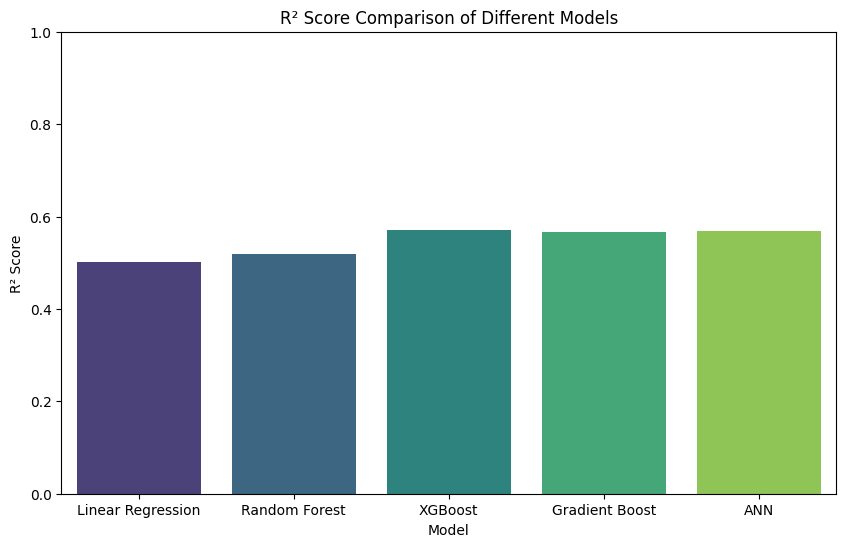

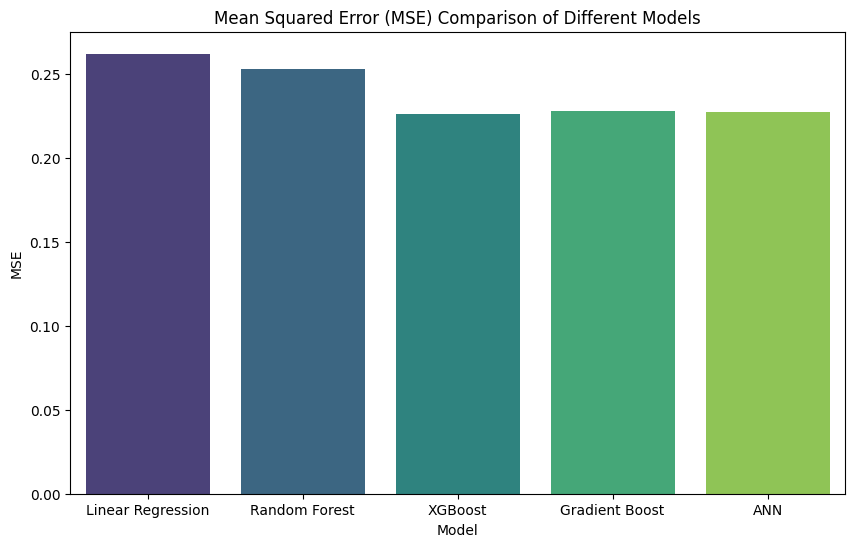

In [53]:
# Plot the R² scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=results_df, palette='viridis')
plt.title('R² Score Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.ylim(0, 1) # R² score is between 0 and 1
plt.show()

# Plot the MSE scores (optional, as R² is often more intuitive)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MSE', data=results_df, palette='viridis')
plt.title('Mean Squared Error (MSE) Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

#key predictor

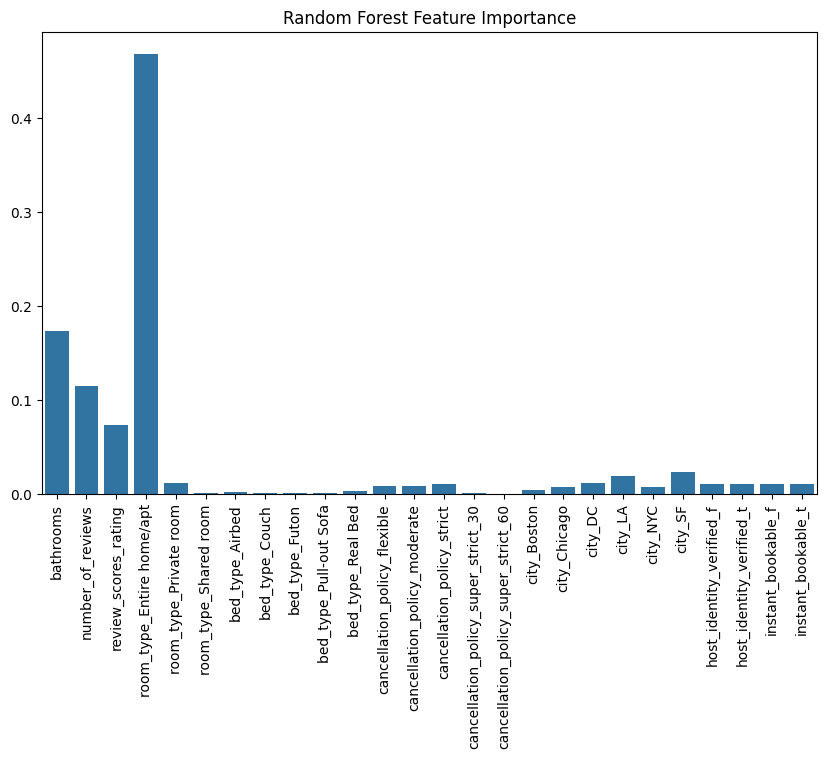

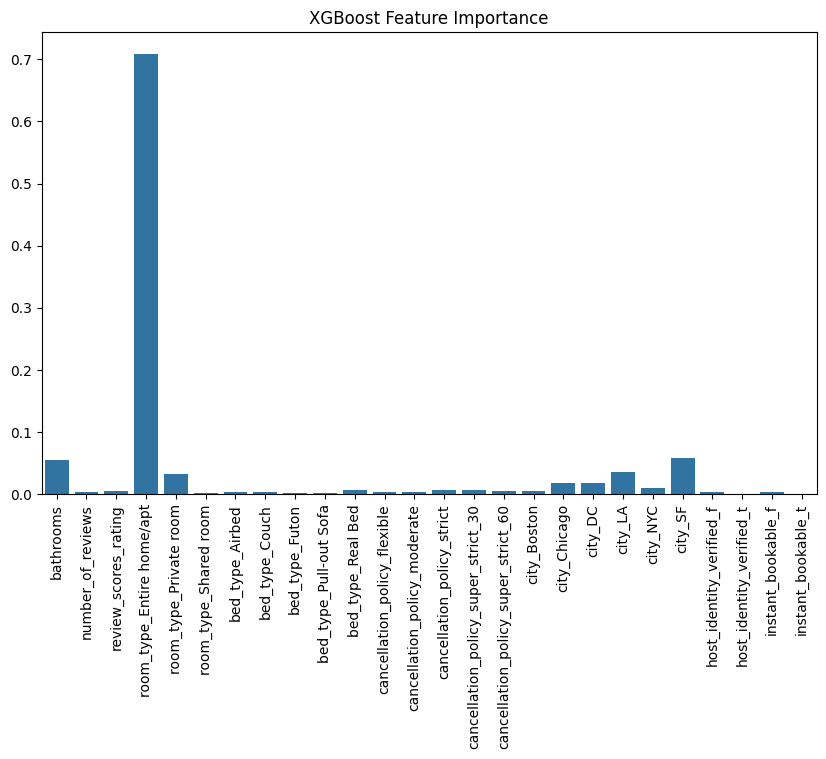

In [54]:
# Feature Importance from Random Forest
rf_importance = pipeline_rf.named_steps['model'].feature_importances_

# Feature Importance from XGBoost
xgb_importance = pipeline_xgb.named_steps['model'].feature_importances_

# Visualizing Feature Importance
numerical_feature_names = numerical_features.tolist()
categorical_transformer = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat']
onehot_feature_names = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_feature_names + list(onehot_feature_names)


features = all_feature_names # Use the feature names after preprocessing

# Plotting Random Forest Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=rf_importance)
plt.xticks(rotation=90)
plt.title('Random Forest Feature Importance')
plt.show()

# Plotting XGBoost Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=xgb_importance)
plt.xticks(rotation=90)
plt.title('XGBoost Feature Importance')
plt.show()

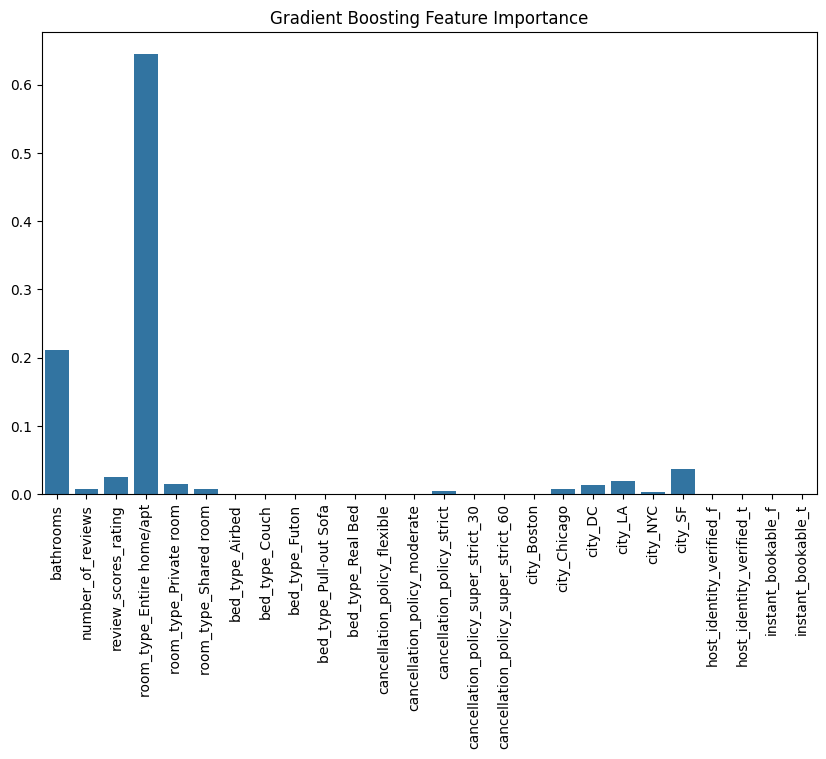

In [55]:

gbr_importance = pipeline_gbr.named_steps['model'].feature_importances_


numerical_feature_names = numerical_features.tolist()

categorical_transformer = pipeline_gbr.named_steps['preprocessor'].named_transformers_['cat']
onehot_feature_names = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_feature_names + list(onehot_feature_names)


features = all_feature_names # Use the feature names after preprocessing

# Plotting Gradient Boosting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=gbr_importance)
plt.xticks(rotation=90)
plt.title('Gradient Boosting Feature Importance')
plt.show()

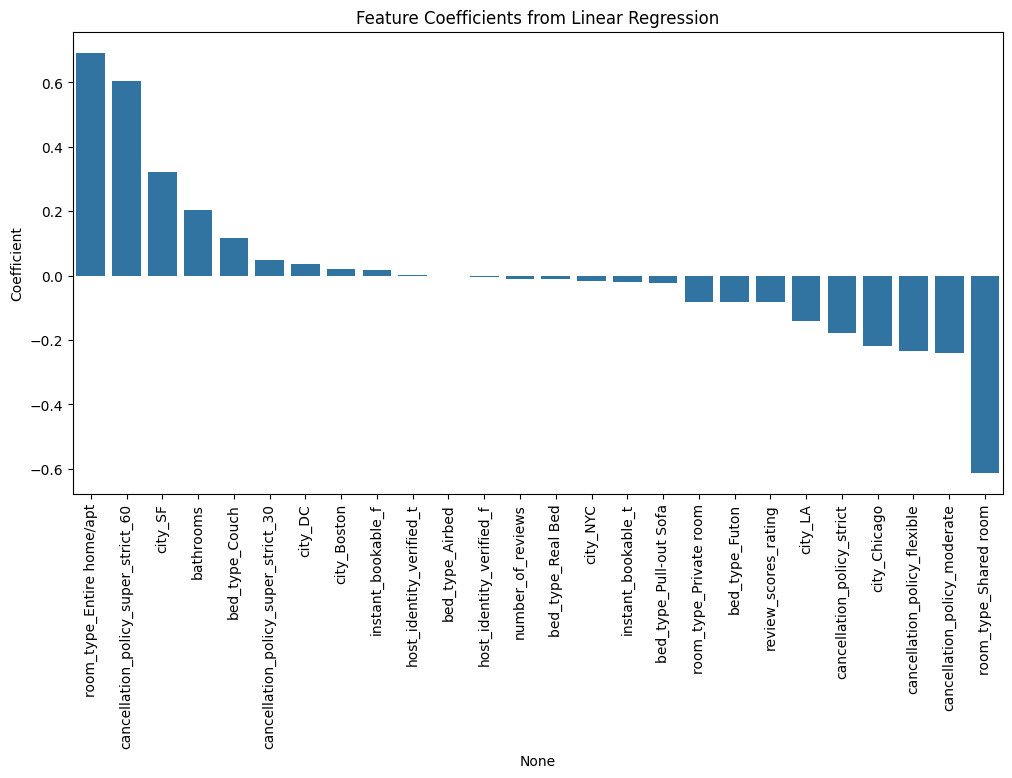

In [56]:

lr_model = pipeline_lr.named_steps['model']  # Access the Linear Regression model from the pipeline

# Getting the coefficients (Effect of Features)
coefficients = pd.DataFrame(lr_model.coef_, index=all_feature_names, columns=['Coefficient'])

# Sorting coefficients
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# Visualizing coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=coefficients.index, y=coefficients['Coefficient'])
plt.xticks(rotation=90)
plt.title('Feature Coefficients from Linear Regression')
plt.show()


In [57]:

train_data = pd.concat([X_train, y_train], axis=1)

# Analyze impact of categorical features on log_price
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns
print("Impact of Categorical Features on log_price (Mean Price per Category):")
for feature in categorical_features:
    if feature != 'log_price':  # Exclude the target variable
        print(f"\nFeature: {feature}")
        display(train_data.groupby(feature)['log_price'].mean().sort_values(ascending=False).reset_index())

# Analyze impact of numerical features on log_price (Correlation)
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
print("\nImpact of Numerical Features on log_price (Correlation Coefficient):")
# Exclude datetime columns from correlation and include log_price for correlation calculation
numerical_features_and_target = [col for col in numerical_features if col != 'log_price'] + ['log_price']

if numerical_features_and_target:
    # Calculate correlation on the DataFrame including numerical features and the target
    correlation_with_price = train_data[numerical_features_and_target].corr()['log_price'].sort_values(ascending=False).reset_index()
    correlation_with_price.columns = ['Feature', 'Correlation with log_price']
    # Remove the correlation of log_price with itself from the output
    correlation_with_price = correlation_with_price[correlation_with_price['Feature'] != 'log_price']
    display(correlation_with_price)
else:
    print("No numerical features available for correlation analysis.")

Impact of Categorical Features on log_price (Mean Price per Category):

Feature: room_type


,room_type,log_price
0,Entire home/apt,5.165564
1,Private room,4.328632
2,Shared room,3.868115



Feature: bed_type


,bed_type,log_price
0,Real Bed,4.794830
1,Pull-out Sofa,4.467381
2,Airbed,4.357012
3,Futon,4.340502
4,Couch,4.312293



Feature: cancellation_policy


,cancellation_policy,log_price
0,super_strict_60,6.382227
1,super_strict_30,5.513750
2,strict,4.887905
3,moderate,4.723328
4,flexible,4.678083



Feature: cleaning_fee


,cleaning_fee,log_price
0,True,4.831397
1,False,4.649275



Feature: city


,city,log_price
0,SF,5.175069
1,DC,4.978990
2,Boston,4.883232
3,LA,4.723992
4,NYC,4.718617
5,Chicago,4.626294



Feature: host_identity_verified


,host_identity_verified,log_price
0,t,4.794945
1,f,4.758249



Feature: instant_bookable


,instant_bookable,log_price
0,f,4.801915
1,t,4.729674



Feature: is_host_has_profile_pic_null


,is_host_has_profile_pic_null,log_price
0,False,4.782927



Feature: is_host_identity_verified_null


,is_host_identity_verified_null,log_price
0,False,4.782927



Feature: is_host_since_null


,is_host_since_null,log_price
0,False,4.782927



Impact of Numerical Features on log_price (Correlation Coefficient):


,Feature,Correlation with log_price
1,bathrooms,0.356981
2,number_of_reviews,-0.034720
3,review_scores_rating,-0.077971


In [58]:
#check is X has property type column
if 'property_type' in X_train.columns:
  print("yes")
else:
  print("no")

no


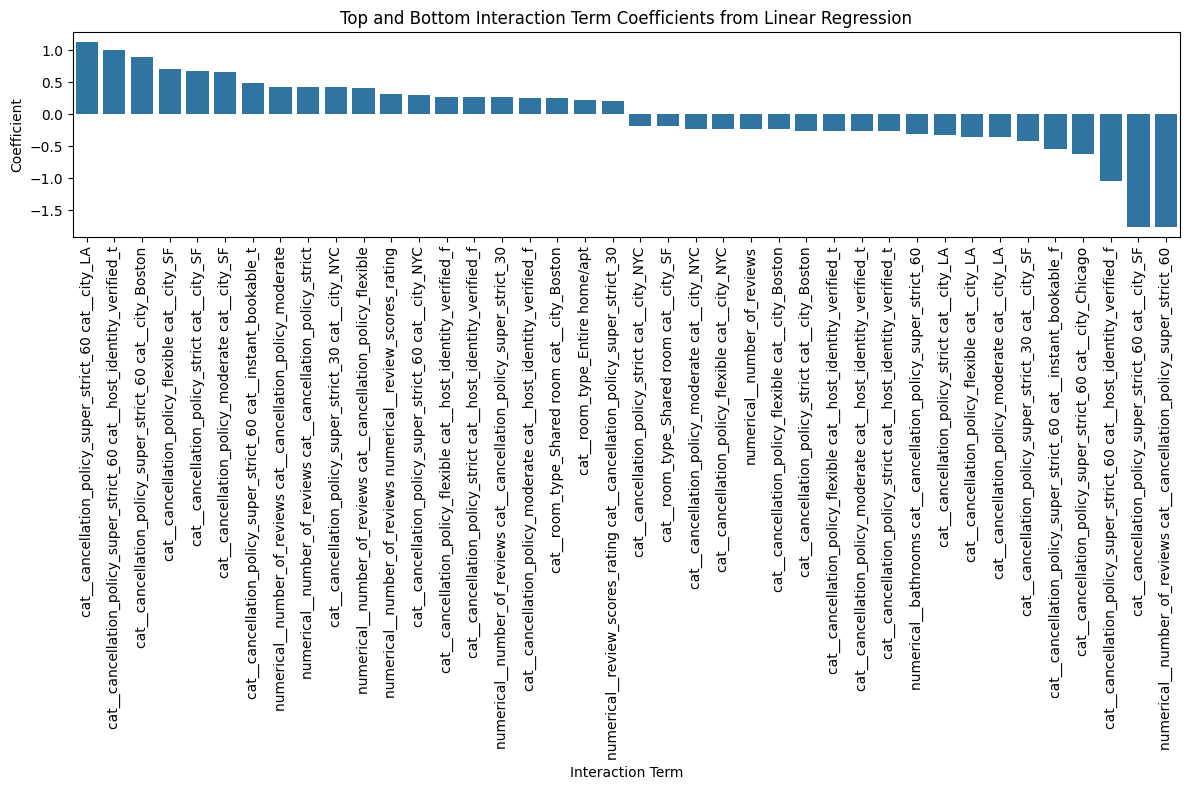

In [59]:

# Apply the preprocessor to transform the data first
X_train_processed = preprocessor.transform(X_train)

# Create interaction terms on the processed numerical data
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_train_processed)

# Fitting a regression model with interaction terms
lr_poly = LinearRegression()
lr_poly.fit(X_poly, y_train)

poly_feature_names = poly.get_feature_names_out(input_features=preprocessor.get_feature_names_out())


coefficients_poly = pd.DataFrame(lr_poly.coef_, index=poly_feature_names, columns=['Coefficient'])


top_n = 20
bottom_n = 20
sorted_coefficients = coefficients_poly.sort_values(by='Coefficient', ascending=False)
top_coefficients = sorted_coefficients.head(top_n)
bottom_coefficients = sorted_coefficients.tail(bottom_n)

# Combine top and bottom coefficients for plotting
plotting_coefficients = pd.concat([top_coefficients, bottom_coefficients])

plt.figure(figsize=(12, 8))
sns.barplot(x=plotting_coefficients.index, y=plotting_coefficients['Coefficient'])
plt.xticks(rotation=90)
plt.title('Top and Bottom Interaction Term Coefficients from Linear Regression')
plt.xlabel('Interaction Term')
plt.ylabel('Coefficient')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()